# Introduction
This notebook contains the code flow for gathering speech signals, segmenting them into voiced/ unvoiced and separate words, and then grouping the words together. Along the way, several quantitative metrics are extracted, and many plots are presented to aid in visualization.

For this code to run, the following packages will need to be installed
- [librosa](https://librosa.org/doc/latest/index.html) `pip install librosa`
- [numpy](https://numpy.org/doc/stable/) `pip install numpy`
- [sounddevice](https://pypi.org/project/sounddevice/) `pip install sounddevice`
- [scipy](https://scipy.org/) `pip install scipy`
- [matplotlib](https://matplotlib.org/stable/users/installing/index.html#install-an-official-release)
- [dtw](https://dynamictimewarping.github.io/py-api/html/index.html#) `pip install dtw-python`
- [sklearn](https://scikit-learn.org/stable/index.html)
- pandas?
- plotly?

They will then need to be imported with the below cell

In [73]:
#################################################################
# Please run the following cell to import all necessary modules #
#################################################################
import librosa
import numpy as np
import sounddevice as sd
import scipy
import matplotlib
from matplotlib import pyplot as plt
import pandas as pd
import plotly.express as px
import plotly.io as pio
from dtw import *
from sklearn.cluster import DBSCAN

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Segmenting into Voiced and Unvoiced Segments

In [2]:
##################################################
# Importing the corresponding Python file        #
# Declaring visualization and auditory functions #
##################################################

from segment_voiced_unvoiced import *

def plot(energy,title,y_label):
    # Create a new figure
    plt.figure(figsize=(10, 4))
    # Plot the energy
    plt.plot(energy)
    # Set the title and labels
    plt.title(title)
    plt.xlabel('Frame')
    plt.ylabel(y_label)
    # Display the plot
    plt.show()

def play(voiced_segments, sample_rate):
    # Concatenate all voiced segments into one array for playback
    voiced_audio = np.concatenate(voiced_segments, axis=0)
    # Play the concatenated voiced audio
    sd.play(voiced_audio, samplerate=sample_rate)
    # Wait for the audio to finish playing
    sd.wait()


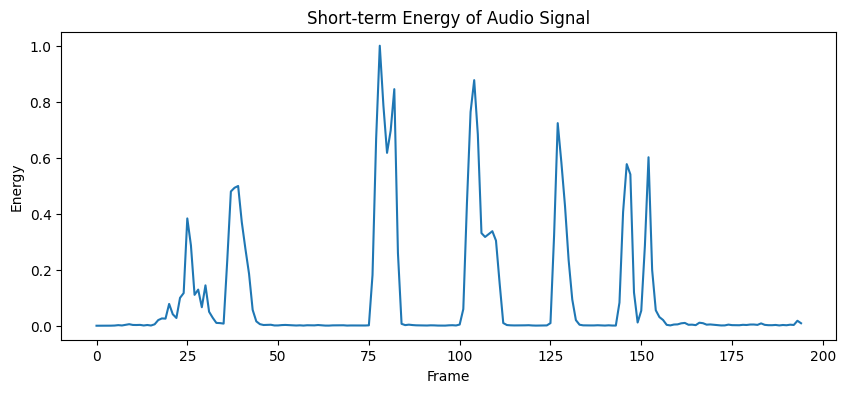

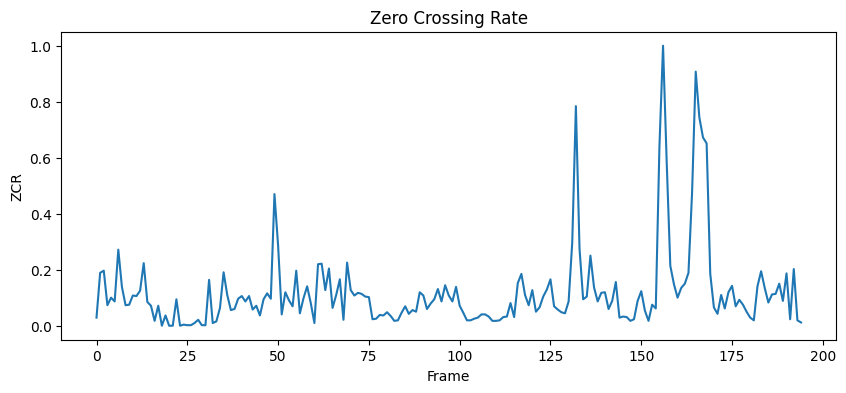

In [6]:
audio_path = 'test_name.wav'
# Load the audio file
y, sample_rate = librosa.load(audio_path)
# Segment audio file
voiced_segments, unvoiced_segments, energy, zcr= segment_audio(y)

# Plot the Energy and Zero Crossing Rate
plot(energy,'Short-term Energy of Audio Signal','Energy')
plot(zcr,'Zero Crossing Rate','ZCR')

# Play separated segments
play(voiced_segments, sample_rate)
play(unvoiced_segments,sample_rate)

# Creating Vector Embeddings

In [78]:
##################################################
# Importing the corresponding Python file        #
# Declaring visualization and auditory functions #
##################################################

from vector_embeddings import Vector_Embeddings

audio_path = 'Rhyme_Words.wav'
# Load the audio file
y, sample_rate = librosa.load(audio_path)

In [84]:

vect_embed = Vector_Embeddings()
print("Sample rate is ", sample_rate)
print("Length of y is ", len(y))
dtw_matrix = vect_embed.embed_vector(y, sample_rate)

num_words = len(dtw_matrix)

colors = ['blue']*((int)(num_words*0.23)) + ['red']*((int)(num_words*0.19)) + ['purple']*((int)(num_words*0.19)) + ['green']*((int)(num_words*0.15)) + ['orange']*((int)(num_words*0.23))
# Addressing rounding issues
colors = colors + ['orange']*(num_words - len(colors))
print("Shape of dtw_matrix is ", np.shape(dtw_matrix))

Sample rate is  22050
Length of y is  575054
Shape of dtw_matrix is  (62, 39)


# Dimensionality Reduction

In [85]:
##################################################
# Importing the corresponding Python file        #
# Declaring visualization and auditory functions #
##################################################
from pca import PCA

def visualize_3d(X_3d, fig_title, colors):
    df = pd.DataFrame(
            {
                "Feature 1": X_3d[:, 0],
                "Feature 2": X_3d[:, 1],
                "Feature 3": X_3d[:, 2],
            }
        )
    fig = px.scatter_3d(
            df,
            x="Feature 1",
            y="Feature 2",
            z="Feature 3",
            title=fig_title,
            color=colors,
            width=960,
            height=700,
        )
    fig.update_traces(
            marker=dict(size=5), selector=dict(mode="markers")
        )  # Customize if needed
    fig.show()


def visualize_2d(X_2d, fig_title, colors):
    df = pd.DataFrame(
            {"Feature 1": X_2d[:, 0], "Feature 2": X_2d[:, 1]}
        )
    fig = px.scatter(
        df, x="Feature 1", y="Feature 2", color=colors, title=fig_title
    )
    fig.show()

In [86]:
dtw_matrix = np.array(dtw_matrix)
dim_red = PCA()
dim_red.fit(dtw_matrix)
retained_vectors = dim_red.transform_rv(dtw_matrix, 0.90)
print("The number of dimensions needed to retain 90% variance is ", len(retained_vectors[0]))
threeD_vectors = dim_red.transform(dtw_matrix, K=3)
visualize_3d(threeD_vectors, "DTW Word Vectors Only 3 Dimensions", colors)
twoD_vectors = dim_red.transform(dtw_matrix, K=2)
visualize_2d(twoD_vectors, "DTW Word Vectors Only 2 Dimensions", colors)

# If you experience the error "Mime type rendering requires nbformat>=4.2.0 but it is not installed"
# Type the following in the terminal: "pip install --upgrade nbformat"
# Then, restart the kernal and re-runn the cells

The number of dimensions needed to retain 90% variance is  5


# Applying a DBScan Model

In [87]:
db_model_threeD = DBSCAN(eps=10.0, min_samples=3).fit(threeD_vectors)
db_colors_threeD = db_model_threeD.labels_
visualize_3d(threeD_vectors, "DBScan on 3D DTW Vectors", db_colors_threeD)

db_model_twoD = DBSCAN(eps=10.0, min_samples=3).fit(twoD_vectors)
db_colors_twoD = db_model_twoD.labels_
visualize_2d(twoD_vectors, "DBScan on 2D DTW Vectors", db_colors_twoD)